In [0]:
!pip install xgboost

In [0]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import numpy as np
import pandas as pd
import re, string
import math
from itertools import product
from google.colab import drive

# Imports for models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

# Make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To format floats
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [0]:
#Data Reading
# Mount drive for data reading
# This will prompt for authorization.
drive.mount('/content/drive')
path = "/content/drive/Shared drives/CIS 519 Project/Code/Dataset/Resampled4/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Read full data path = "/content/drive/Shared drives/CIS 519 Project/Code/Dataset/"
df_train = pd.read_csv(path + 'train.csv')
df_val = pd.read_csv(path + 'validation.csv')
#df_train = df_train.sample(10000)
#df_val = df_val.sample(5000)

In [0]:
df_train.head(10)

,id,target,comment_text,female,male,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,identity_annotator_count,toxicity_annotator_count,created_date
0,5367475,0.50000,This is an insult to all immigrants who took t...,0.80000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10000,10,10,2017-06-06 17:53:11.976493+00
1,389581,0.16667,"Eric, I was unaware that Obama had a line of p...",0.00000,0.60000,0.00000,0.00000,0.00000,0.00000,0.00000,0.90000,0.00000,10,6,2016-07-15 23:22:57.603863+00
2,259203,0.60000,"""malign her character because of alleged illeg...",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,10,2016-03-26 19:14:41.102508+00
3,6274158,0.00000,"Couldn't agree more with your last sentence, E...",0.00000,0.70000,0.90000,0.70000,0.00000,0.00000,0.00000,0.00000,0.00000,10,4,2017-11-02 15:49:53.222384+00
4,5435081,0.50000,"The liberal, married, gay Black woman who took...",0.83333,0.16667,0.83333,0.00000,0.00000,0.00000,0.83333,0.00000,0.00000,6,10,2017-06-18 13:26:29.297687+00
5,5693877,0.00000,"Get over it, two men took to the ring and one ...",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,4,2017-08-01 02:59:30.400500+00
6,5801144,0.60000,"Yes, yes, it's ""The Media"" who forced Trump to...",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,4,10,2017-08-19 16:02:37.201001+00
7,5078252,0.50000,"""cannon fodder"" - they are ""acceptable losses""...",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,10,2017-03-31 18:03:36.139268+00
8,5277082,0.00000,"No, not who cares, as in who cares, rather htt...",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,4,2017-05-19 14:33:37.520110+00
9,489731,0.82857,The hate of white males from the progressive p...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,4,70,2016-09-24 04:44:47.907794+00


In [0]:
df_val.head(10)

,id,target,comment_text,female,male,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,identity_annotator_count,toxicity_annotator_count,created_date
0,400154,0.00000,Donald always has been a lefty wing Manhattani...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,4,2016-07-24 22:43:28.495610+00
1,5092755,0.00000,"Again, to be fair, it was just the one guy who...",0.80000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5,4,2017-04-04 20:08:40.823984+00
2,797853,0.60000,I am going to start an organization so ALL ord...,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,10,2017-01-06 04:54:33.684047+00
3,5046660,1.00000,LMAO...what on god's green earth makes you thi...,0.10000,0.80000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10,4,2017-03-23 23:54:30.927369+00
4,882416,0.00000,"Master Yoda told me; Hmmmm...Hmmm.. ""Much whin...",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,4,2017-01-23 04:17:54.377161+00
5,984833,0.16667,I am SO happy and grateful to see people stand...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,6,2017-02-12 07:08:51.852690+00
6,5499900,0.16667,Trump has been objectifying women for decades....,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,6,2017-06-29 19:30:21.743759+00
7,728632,0.50000,Ms. Kurdi claims that Canada is partly respons...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,10,2016-12-19 15:24:50.573840+00
8,5408070,0.80000,The Catholic church confuses forgiveness with ...,0.00000,0.60000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10,10,2017-06-13 18:26:08.994210+00
9,5253827,0.00000,"""Cultural Appropriation"" as an accusation is a...",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,4,4,2017-05-14 02:35:25.722340+00


In [0]:
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(df_train.comment_text)
test_features = vectorizer.transform(df_val.comment_text)

i = 15000
j = 15000

#An example of what features have inside
words = vectorizer.get_feature_names()[i:i+10]
pd.DataFrame(train_features[j:j+7,i:i+10].todense(), columns=words)

,kenneth,kenney,kenny,kenoi,kentucky,kenya,kenyan,kept,kermit,kerns


In [0]:
#Generate labels
toxicity_labels_train = list(df_train.target.apply(lambda x: 1 if x >= 0.5 else 0))
toxicity_labels_val = list(df_val.target.apply(lambda x: 1 if x >= 0.5 else 0))

In [0]:
print(toxicity_labels_train[:50])

[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


In [0]:
print(toxicity_labels_val[:50])

[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [0]:
print("Different words:",len(vectorizer.get_feature_names()))

Different words: 30071


In [0]:
def performance(y_true, pred, ann=True):
    acc = accuracy_score(y_true, pred[:,1]>0.5)
    auc = roc_auc_score(y_true, pred[:,1])
    fpr, tpr, thr = roc_curve(y_true, pred[:,1])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
    plt.plot(fpr, tpr, color='royalblue', linewidth="3")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    if ann:
        ax.annotate("Acc: %0.2f" % acc, (0.2,0.7), size=14)
        ax.annotate("AUC: %0.2f" % auc, (0.2,0.6), size=14)
        
def metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    columns = y_true.shape[1]
    column_losses = []
    for i in range(0, columns):
        column_losses.append(log_loss(y_true[:, i], y_pred[:, i]))
    return np.array(column_losses).mean()

## **Naive Bayes Classifier**

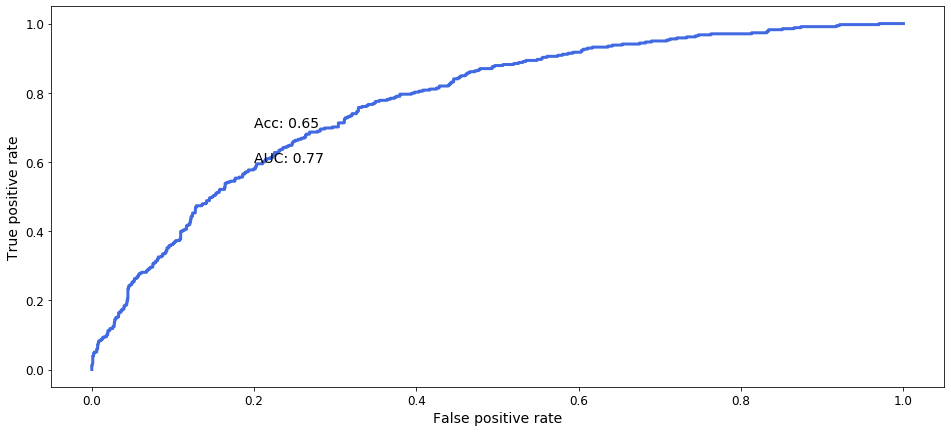

In [0]:
model1 = MultinomialNB()
model1.fit(train_features, toxicity_labels_train)
pred1 = model1.predict_proba(test_features)

performance(toxicity_labels_val, pred1)

In [0]:
comment = "What a stupid comment is the one you made you dumbass"
print(model1.predict(vectorizer.transform([comment]))[0])

1


In [0]:
comment = "Great comment, thanks for contributing"
print(model1.predict(vectorizer.transform([comment]))[0])

0


# **Bag-of-words features with the tf-idf algorithm**

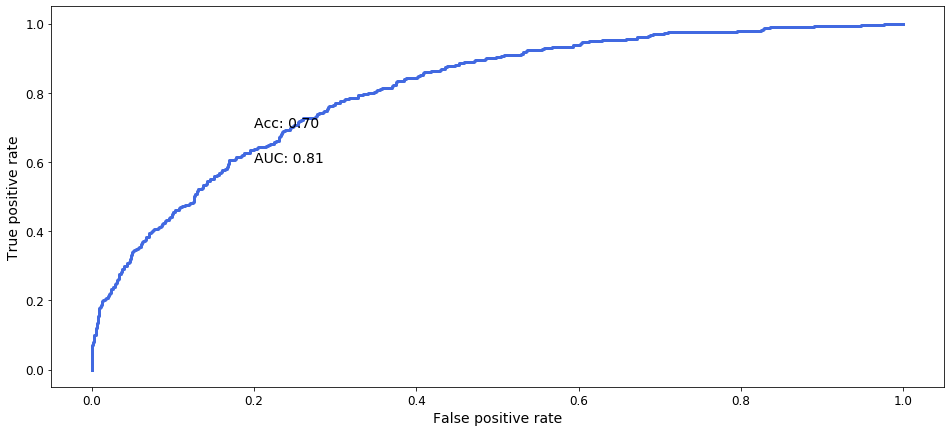

In [0]:
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(df_train.comment_text)

model2 = MultinomialNB()
model2.fit(train_features, toxicity_labels_train)

pred2 = model2.predict_proba(vectorizer.transform(df_val.comment_text))
performance(toxicity_labels_val, pred2)

# Optimizing Model Parameters (Skip)

In [0]:
def build_model(Tfid = True, max_features=None, min_df=1, nb_alpha=1.0):
    if Tfid:
        vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
    else:
        vectorizer = CountVectorizer(max_features=max_features, min_df=min_df)
    features = vectorizer.fit_transform(df_train.comment_text)
    model = MultinomialNB(alpha=nb_alpha)
    model.fit(features, toxicity_labels_train)
    pred = model.predict_proba(vectorizer.transform(df_val.comment_text))
    return {
        "Tfid": Tfid,
        "max_features": max_features,
        "min_df": min_df,
        "nb_alpha": nb_alpha,
        "auc": roc_auc_score(toxicity_labels_val, pred[:,1])
    }

In [0]:
param_values = {
  "Tfid": [True,False],
  "max_features": [10000, 30000, 50000, None],
  "min_df": [1,2,3],
  "nb_alpha": [0.01, 0.1, 1.0]
}

results = []
max_auc = 0

for p in product(*param_values.values()):
    res = build_model(**dict(zip(param_values.keys(), p)))
    results.append(res)
    if res.get('auc')>max_auc:
        max_auc = res.get('auc')
        Tfid_opt = res.get('Tfid')
        max_features_opt = res.get('max_features')
        min_df_opt = res.get('min_df')
        nb_alpha_opt = res.get('nb_alpha')
    print(res)

In [0]:
if Tfid_opt:
    vectorizer = TfidfVectorizer(max_features=max_features_opt, min_df=min_df_opt)
else:
    vectorizer = CountVectorizer(max_features=max_features, min_df=min_df)
    
features = vectorizer.fit_transform(df_train.comment_text)

model2_opt = MultinomialNB(alpha=nb_alpha_opt)
model2_opt.fit(features, toxicity_labels_train)

pred2_opt = model2_opt.predict_proba(vectorizer.transform(df_val.comment_text))
performance(toxicity_labels_val, pred2_opt)

In [0]:
roc_auc_score(toxicity_labels_val, pred2_opt[:,1])

# Random Forest Classifier

In [0]:
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(df_train.comment_text)

model5 = RandomForestClassifier(n_estimators=100, random_state=0)
model5.fit(train_features, toxicity_labels_train)

pred4 = model5.predict_proba(vectorizer.transform(df_val.comment_text))
performance(toxicity_labels_val, pred4)

# AdaBoost Classifier

In [0]:
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(df_train.comment_text)

# model4 = AdaBoostClassifier(n_estimators=100, random_state=0)
# model4.fit(train_features, toxicity_labels_train)

# pred4 = model4.predict_proba(vectorizer.transform(df_val.comment_text))
# performance(toxicity_labels_val, pred4)

# XGBoost Classifier

In [0]:
train_features.shape

(10974, 30071)

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(train_features, toxicity_labels_train)

# Training
print("XGBoost Training Metrics")
preds = xg_reg.predict(train_features)
preds_train = [round(value) for value in preds]
acc = accuracy_score(toxicity_labels_train, preds_train)
print('Accuracy Score', acc)
pre = precision_score(toxicity_labels_train, preds_train)
print('Precision Score', pre)
rec = recall_score(toxicity_labels_train, preds_train)
print('Recall Score', rec)
f1 = f1_score(toxicity_labels_train, preds_train, average="weighted")
print('F1 Score', f1)

XGBoost Training Metrics
Accuracy Score 0.8313285948605795
Precision Score 0.8373937677053824
Recall Score 0.8174778761061947
F1 Score 0.8312824975062207


In [0]:
# Validation
print("XGBoost Validation Metrics")
preds = xg_reg.predict(vectorizer.transform(df_val.comment_text))
preds_val = [round(value) for value in preds]
acc = accuracy_score(toxicity_labels_val, preds_val)
print('Accuracy Score', acc)
pre = precision_score(toxicity_labels_val, preds_val)
print('Precision Score', pre)
rec = recall_score(toxicity_labels_val, preds_val)
print('Recall Score', rec)
f1 = f1_score(toxicity_labels_val, preds_val, average="weighted")
print('F1 Score', f1)

XGBoost Validation Metrics
Accuracy Score 0.59
Precision Score 0.24361702127659574
Recall Score 0.6775147928994083
F1 Score 0.6412269584524867


# XGBoost Fairness Metrics

In [0]:
#Generate protected attribute - gender
def extract_female_gender(x):
  if np.isnan(x.female) or x.female < 0.3:
      return 0
  else:
    return 1

In [0]:
#Generate unprotected attribute labels
def get_unprotected_class(list_of_protected):
  new = [1 if i == 0 else 0 for i in list_of_protected]
  return new

In [0]:
#FAIRNESS METRICS FUNCTION
def get_fairness_metrics(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

  def get_toxicity_rates(y_pred, protected_labels, non_protected_labels, thres):
    protected_ops = y_pred[protected_labels == 1]
    protected_prob = sum(protected_ops)/len(protected_ops)

    non_protected_ops = y_pred[non_protected_labels == 1]
    non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

    return np.round(protected_prob, 2), np.round(non_protected_prob, 2)

  def get_true_positive_rates(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

    protected_ops = y_pred[np.bitwise_and(protected_labels == 1, actual_labels == 1)]
    protected_prob = sum(protected_ops)/len(protected_ops)

    non_protected_ops = y_pred[np.bitwise_and(non_protected_labels == 1, actual_labels == 1)]
    non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

    return np.round(protected_prob, 2), np.round(non_protected_prob, 2)


  def get_false_positive_rates(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

    protected_ops = y_pred[np.bitwise_and(protected_labels == 1, actual_labels ==0)]
    protected_prob = sum(protected_ops)/len(protected_ops)

    non_protected_ops = y_pred[np.bitwise_and(non_protected_labels == 1, actual_labels == 0)]
    non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

    return np.round(protected_prob, 2), np.round(non_protected_prob, 2)

  def demographic_parity(y_pred, protected_labels, non_protected_labels, thres):

    protected_ops = y_pred[protected_labels == 1]
    protected_prob = sum(protected_ops)/len(protected_ops)

    non_protected_ops = y_pred[non_protected_labels == 1]
    non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

    return abs(protected_prob - non_protected_prob) #later take absolute diff - but we want to show females predicted more toxic than male

  # | P_female(C = 1| Y = 1) - P_male(C = 1 | Y = 1) | < thres
  def true_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

    protected_ops = y_pred[np.bitwise_and(protected_labels == 1, actual_labels == 1)]
    protected_prob = sum(protected_ops)/len(protected_ops)

    non_protected_ops = y_pred[np.bitwise_and(non_protected_labels == 1, actual_labels == 1)]
    non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

    return abs(protected_prob - non_protected_prob) #later take absolute diff - but we want to show females predicted more toxic than male

  # | P_female(C = 1| Y = 0) - P_male(C = 1 | Y = 0) | < thres
  def false_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

    protected_ops = y_pred[np.bitwise_and(protected_labels == 1, actual_labels ==0)]
    protected_prob = sum(protected_ops)/len(protected_ops)

    non_protected_ops = y_pred[np.bitwise_and(non_protected_labels == 1, actual_labels == 0)]
    non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

    return abs(protected_prob - non_protected_prob) #later take absolute diff - but we want to show females predicted more toxic than male


  # Satisfy both true positive parity and false positive parity
  def equalized_odds(actual_labels, y_pred, protected_labels, non_protected_labels, thres):
    return true_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres) + false_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres)

  female_tox_rate, nf_tox_rate = get_toxicity_rates(y_pred, protected_labels, non_protected_labels, thres)
  female_tp_rate, nf_tp_rate = get_true_positive_rates(actual_labels, y_pred, protected_labels, non_protected_labels, thres)
  female_fp_rate, nf_fp_rate = get_false_positive_rates(actual_labels, y_pred, protected_labels, non_protected_labels, thres)
  demo_parity = demographic_parity(y_pred, protected_labels, non_protected_labels, thres)
  tp_parity = true_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres)
  fp_parity = false_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres)
  equ_odds = equalized_odds(actual_labels, y_pred, protected_labels, non_protected_labels, thres)

  return female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds

In [0]:
# Train - Identity and Unprotected Labels
identity_labels_train = list(df_train.apply(extract_female_gender, axis = 1))
unprotected_labels_train = get_unprotected_class(identity_labels_train)

actual_labels = np.array(toxicity_labels_train)
y_pred = np.array(preds_train).astype(int)
protected_labels = np.array(identity_labels_train)
non_protected_labels = np.asarray(get_unprotected_class(identity_labels_train))

print(actual_labels)
print(y_pred)
print(protected_labels)
print(non_protected_labels)

[1 0 1 ... 0 1 1]
[1 0 1 ... 0 1 0]
[1 0 1 ... 0 1 0]
[0 1 0 ... 1 0 1]


In [0]:
# TRAIN FAIRNESS METRICS
thres = 0.5

female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds = get_fairness_metrics(actual_labels, y_pred, protected_labels, non_protected_labels, thres)

print("XGBoost Fairness Metrics - Train")
print("Toxicity Prediction Rates: ", "Female -", female_tox_rate, "Non-Female - ", nf_tox_rate)
print("True Positive Prediction Rates: ", "Female -", female_tp_rate, "Non-Female - ", nf_tp_rate)
print("False Positive Prediction Rates: ", "Female -", female_fp_rate, "Non-Female - ", nf_fp_rate)
print("Demographic Parity: ", demo_parity)
print("True Positive Parity: ", tp_parity)
print("False Positive Parity: ", fp_parity)
print("Equalized Odds: ", equ_odds)

XGBoost Fairness Metrics - Train
Toxicity Prediction Rates:  Female - 0.8 Non-Female -  0.15
True Positive Prediction Rates:  Female - 0.95 Non-Female -  0.49
False Positive Prediction Rates:  Female - 0.47 Non-Female -  0.01
Demographic Parity:  0.6523809751616978
True Positive Parity:  0.4573677259947176
False Positive Parity:  0.4592667750242336
Equalized Odds:  0.9166345010189512


In [0]:
# Validation - Identity and Unprotected Labels
identity_labels_val = list(df_val.apply(extract_female_gender, axis = 1))
unprotected_labels_val = get_unprotected_class(identity_labels_val)

actual_labels = np.array(toxicity_labels_val)
y_pred = np.array(preds_val).astype(int)
protected_labels = np.array(identity_labels_val)
non_protected_labels = np.asarray(get_unprotected_class(identity_labels_val))

print(actual_labels)
print(y_pred)
print(protected_labels)
print(non_protected_labels)

[0 0 1 ... 0 0 0]
[1 1 0 ... 1 0 1]
[1 1 0 ... 1 1 1]
[0 0 1 ... 0 0 0]


In [0]:
# VALIDATION FAIRNESS METRICS
thres = 0.5

female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds = get_fairness_metrics(actual_labels, y_pred, protected_labels, non_protected_labels, thres)

print("XGBoost Fairness Metrics - Validation")
print("Toxicity Prediction Rates: ", "Female -", female_tox_rate, "Non-Female - ", nf_tox_rate)
print("True Positive Prediction Rates: ", "Female -", female_tp_rate, "Non-Female - ", nf_tp_rate)
print("False Positive Prediction Rates: ", "Female -", female_fp_rate, "Non-Female - ", nf_fp_rate)
print("Demographic Parity: ", demo_parity)
print("True Positive Parity: ", tp_parity)
print("False Positive Parity: ", fp_parity)
print("Equalized Odds: ", equ_odds)

XGBoost Fairness Metrics - Validation
Toxicity Prediction Rates:  Female - 0.71 Non-Female -  0.12
True Positive Prediction Rates:  Female - 0.89 Non-Female -  0.41
False Positive Prediction Rates:  Female - 0.68 Non-Female -  0.06
Demographic Parity:  0.5908625586156793
True Positive Parity:  0.4794929157345264
False Positive Parity:  0.6205786333445908
Equalized Odds:  1.1000715490791173


# Word2Vec (Skip below)

In [0]:
stop_words = set(['all', "she'll", "don't", 'being', 'over', 'through', 
'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should',
"he'd", 'to', 'only', "there's", 'those', 'under', 'ours', 'has', 
"haven't", 'do', 'them', 'his', "they'll", 'very', "who's", "they'd", 
'cannot', "you've", 'they', 'not', 'during', 'yourself', 'him', 'nor', 
"we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where', 
"mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'some', 
'up', 'are', 'further', 'ourselves', 'out', 'what', 'for', 'while', 
"wasn't", 'does', "shouldn't", 'above', 'between', 'be', 'we', 'who', 
"you're", 'were', 'here', 'hers', "aren't", 'by', 'both', 'about', 'would', 
'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own', 
'into', 'whom', 'down', "hadn't", "couldn't", 'your', "doesn't", 'from', 
"how's", 'her', 'their', "it's", 'there', 'been', 'why', 'few', 'too', 
'themselves', 'was', 'until', 'more', 'himself', "where's", "i've", 'with', 
"didn't", "what's", 'but', 'herself', 'than', "here's", 'he', 'me', 
"they're", 'myself', 'these', "hasn't", 'below', 'ought', 'theirs', 'my', 
"wouldn't", "we'd", 'and', 'then', 'is', 'am', 'it', 'an', 'as', 'itself', 
'at', 'have', 'in', 'any', 'if', 'again', 'no', 'that', 'when', 'same', 
'how', 'other', 'which', 'you', "shan't", 'our', 'after', "let's", 'most', 
'such', 'on', "he'll", 'a', 'off', 'i', "she'd", 'yours', "you'll", 'so', 
"we're", "she's", 'the', "that's", 'having', 'once'])

def tokenize(docs):
    pattern = re.compile('[\W_]+', re.UNICODE)
    sentences = []
    for d in docs:
        sentence = d.lower().split(" ")
        sentence = [pattern.sub('', w) for w in sentence]
        sentences.append( [w for w in sentence if w not in stop_words] )
    return sentences

def featurize_w2v(model, sentences):
    f = np.zeros((len(sentences), model.vector_size))
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

def delete_nans(features):
    rows_to_delete = []
    for i in range(len(features)):
        if np.isnan(features[i].sum()):
            rows_to_delete.append(i)
    return rows_to_delete

In [0]:
sentences = df_train.comment_text #tokenize(df_train.comment_text)
model = Word2Vec(sentences, size=500, window=5, min_count=6, sample=1e-3, workers=2)
model.init_sims(replace=True)

features_w2v = featurize_w2v(model, sentences)

rows_to_delete = delete_nans(features_w2v)
features_w2v = np.delete(features_w2v, rows_to_delete, 0)

df_toxicity_train = pd.DataFrame(toxicity_labels_train)
model3 = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_features="log2")
model3.fit(features_w2v, df_toxicity_train.drop(df_train.index[rows_to_delete]))

test_sentences = df_val.comment_text #tokenize(df_val.comment_text)
test_features_w2v = featurize_w2v(model, test_sentences)

In [0]:
df_toxicity_test = pd.DataFrame(toxicity_labels_test)
pred3 = model3.predict_proba(test_features_w2v)
performance(df_toxicity_test.drop(df_val.index[rows_to_delete]), pred3)

In [0]:
roc_auc_score(df_toxicity_test.drop(df_val.index[rows_to_delete]), pred3[:,1])

In [0]:

# | P_female(C = 1) - P_male(C = 1) | < thres
def demographic_parity(y_pred, protected_labels, non_protected_labels, thres):

  protected_ops = y_pred[protected_labels == 1]
  protected_prob = sum(protected_ops)/len(protected_ops)

  non_protected_ops = y_pred[non_protected_labels == 1]
  non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

  return abs(protected_prob - non_protected_prob)

# | P_female(C = 1| Y = 1) - P_male(C = 1 | Y = 1) | < thres
def true_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

  protected_ops = y_pred[np.bitwise_and(protected_labels == 1, actual_labels == 1)]
  protected_prob = sum(protected_ops)/len(protected_ops)

  non_protected_ops = y_pred[np.bitwise_and(non_protected_labels == 1, actual_labels == 1)]
  non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

  return abs(protected_prob - non_protected_prob)

# | P_female(C = 1| Y = 0) - P_male(C = 1 | Y = 0) | < thres
def false_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):

  protected_ops = y_pred[np.bitwise_and(protected_labels == 1, actual_labels ==0)]
  protected_prob = sum(protected_ops)/len(protected_ops)

  non_protected_ops = y_pred[np.bitwise_and(non_protected_labels == 1, actual_labels == 0)]
  non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

  return abs(protected_prob - non_protected_prob)


# Satisfy both true positive parity and false positive parity
def equalized_odds(actual_labels, y_pred, protected_labels, non_protected_labels, thres):
  return true_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres) > thres and false_positive_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres) > thres

# | P_female(Y = 1| C = 1) - P_male(Y = 1 | C = 1) | < thres
def pos_predictive_val_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):
  
  protected_ops = actual_labels[np.bitwise_and(protected_labels == 1, y_pred ==1)]
  protected_prob = sum(protected_ops)/len(protected_ops)

  non_protected_ops = actual_labels[np.bitwise_and(non_protected_labels == 1, y_pred == 1)]
  non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

  return abs(protected_prob - non_protected_prob)


# | P_female(Y = 1| C = 0) - P_male(Y = 1 | C = 0) | < thres
def neg_predictive_val_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):
  
  protected_ops = actual_labels[np.bitwise_and(protected_labels == 1, y_pred ==0)]
  protected_prob = sum(protected_ops)/len(protected_ops)

  non_protected_ops = actual_labels[np.bitwise_and(non_protected_labels == 1, y_pred == 0)]
  non_protected_prob = sum(non_protected_ops)/len(non_protected_ops)

  return abs(protected_prob - non_protected_prob)


# Satisfy both positive value parity and negative value parity
def predictive_value_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres):
  return pos_predictive_val_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres) > thres and neg_predictive_val_parity(actual_labels, y_pred, protected_labels, non_protected_labels, thres) > thres

def p_rule(y_pred, protected_labels, threshold = 0.5):
    y_z_1 = y_pred[protected_labels == 1] > threshold if threshold else y_pred[protected_labels == 1]
    y_z_0 = y_pred[protected_labels == 0] > threshold if threshold else y_pred[protected_labels == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1 / odds]) * 100